# Prediction Rate

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,PowerTransformer,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression,SelectKBest,f_classif
from scipy.stats import mannwhitneyu,ttest_ind,shapiro
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.feature_selection import SelectKBest


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
import optuna

In [2]:
dataset = pd.read_excel('data/CovidCare_Nature.xlsx',header=1,index_col=0)

In [3]:
# Fill Nan variables with 0 for commorbidites and symptoms

dataset.iloc[:,18:-2]=dataset.iloc[:,18:-2].fillna(0)

## Drop Low I - High II

In [4]:
# Remove subjects who get sieropositive during the period of observation

index_low_hig = dataset[(dataset['IgG class phase I']=='LOW')&(dataset['IgG class phase II']=='HIG')].index


In [5]:
dataset = dataset.drop(index_low_hig)

In [6]:
dataset.shape

(4737, 69)

## Rate delta & BMI

In [7]:
dataset['RATE'] = (dataset['Delta Phase I - Phase II'])/(dataset['Delta days  Phase I - Phase II'])
dataset['BMI'] = dataset['Weight']/np.power(dataset['Height']/100,2)

## Setting types of data

In [8]:
list_categorical = []
counter = 0
for col in dataset.columns:
    if dataset[col].dtype == 'object':

        counter+=1
        dataset[col]=dataset[col].astype('category')
        list_categorical.append(col)
for col in dataset.columns:
    if dataset[col].dtype == 'float' or dataset[col].dtype == 'int':
        if dataset[col].value_counts().shape[0] < 5:

            dataset[col]=dataset[col].astype('category')
            counter+=1
            #list_categorical.append(col)




counter = 0            
list_numerical = []            

for col in dataset.columns:
    if dataset[col].dtype == 'float' or dataset[col].dtype == 'int':
        if dataset[col].value_counts().shape[0] >5:

            counter+=1
            list_numerical.append(col)
            dataset[col]=dataset[col].astype('float')


list_temporal = []
counter=0

for col in dataset.columns:
    if dataset[col].dtype == '<M8[ns]':

        counter+=1
        list_temporal.append(col)

        


## Drop features which are not included in the study

In [9]:

dataset=dataset.drop(['Date survey phase I','Date survey Phase II','Tot symptoms Phase I',
                      'Date IgG phase I','Date IgG phase II',
                     'IgG class phase II','Delta Phase I - Phase II class'],axis=1)

## One Hot Encoding for Categorical

In [10]:
dataset.columns

Index(['Age', 'Age_class', 'Sex', 'Site', 'Role', 'Weight', 'Height',
       'Cigarette n/die', 'IgG phase I', 'IgG class phase I', 'IgG phase II',
       'Delta Phase I - Phase II', 'Delta days  Phase I - Phase II', 'Fever',
       'Low-grade Fever', 'Cough', 'Sore throath', 'Muscle pain', 'Asthenia',
       'Anosmia/dysgeusia', 'Gastrointestinal disorders', 'Conjunctivitis',
       'Dyspnea', 'Chest pain', 'Tachycardia', 'Pneumonia', 'Fever.1',
       'Low-grade Fever.1', 'Cough.1', 'Sore throath.1', 'Muscle pain.1',
       'Asthenia.1', 'Anosmia/dysgeusia.1', 'Gastrointestinal disorders.1',
       'Conjunctivitis.1', 'Dyspnea.1', 'Chest pain.1', 'Tachycardia.1',
       'Pneumonia.1', 'Tot symptoms Phase II',
       'Chronic obstructive pulmonary disease', 'Asthma', 'Dyslipidemia',
       'Active neoplasia', 'Past neoplasia', 'Chronic heart failure',
       'Hypertension', 'Past Coronary heart disease', 'Atrial fibrillation',
       'Past Stroke/TIA', 'Steatosis / Cirrhosis', 'Chroni

In [11]:
for col in dataset.columns:
    if col[-2:]=='.1':
        dataset=dataset.rename(columns={col:col[:-2]+'_PhaseII'})

In [12]:
dataset=pd.get_dummies(dataset,drop_first=True)

# Pipeline classification

In [13]:
# Select upper 90 quantile and lower 10 quantile

dataset_rate = dataset[(dataset['RATE']>dataset['RATE'].quantile(0.90))|(dataset['RATE']<dataset['RATE'].quantile(0.1))]

In [14]:
print('Quantile 0.9:',dataset['RATE'].quantile(0.90))
print('Quantile 0.1:',dataset['RATE'].quantile(0.1))

Quantile 0.9: 0.0047072419106318425
Quantile 0.1: -0.03313019891500903


In [15]:
dataset_rate.shape

(908, 90)

In [16]:
# Drop missing values
dataset_rate=dataset_rate.drop(dataset_rate[dataset_rate.isna().sum(axis=1)>0].index)

In [17]:
dataset_rate.shape

(899, 90)

In [18]:
# Definition of X and y

X = dataset_rate.drop(['IgG phase II','Delta Phase I - Phase II','RATE'],axis=1)
y =dataset_rate['RATE']


y = [0 if x<0 else 1 for x in y]


# Partition of train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.20, random_state=42)

In [19]:
# Standardization of features

'''for col in X.select_dtypes('float').columns:
   
    if X_train[col].skew()>1 or X_train[col].skew()<-1:
        
        scaler=RobustScaler().fit(X_train[col].values.reshape(-1, 1))
        X_train[col] = scaler.transform(X_train[col].values.reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))
        
    else:
        scaler=PowerTransformer().fit(X_train[col].values.reshape(-1, 1))
        X_train[col] = scaler.transform(X_train[col].values.reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))
            '''

"for col in X.select_dtypes('float').columns:\n   \n    if X_train[col].skew()>1 or X_train[col].skew()<-1:\n        \n        scaler=RobustScaler().fit(X_train[col].values.reshape(-1, 1))\n        X_train[col] = scaler.transform(X_train[col].values.reshape(-1, 1))\n        X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))\n        \n    else:\n        scaler=PowerTransformer().fit(X_train[col].values.reshape(-1, 1))\n        X_train[col] = scaler.transform(X_train[col].values.reshape(-1, 1))\n        X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))\n            "

In [20]:
print('Balance:',round(np.sum(y)/len(y)*100,2),'%')
print('Records:', len(y))

Balance: 49.5 %
Records: 899


In [21]:
## Bayesian Hyperparameter search 

## Uncomment to perform it

'''from sklearn.svm import SVC
from sklearn.linear_model import BayesianRidge,LogisticRegression,SGDClassifier,Lasso
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel,RFECV,SelectKBest,mutual_info_classif,f_classif
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
#from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
import warnings

def Pipeline(trial):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ## Feature selection with ElasticNet model
        cv = StratifiedKFold(4)
        selector = SelectKBest(f_classif,k = trial.suggest_int('k',5,50))
        
        
        X_train_new = selector.fit_transform(X_train,y_train)
        
            
        
        
        classifier_name = trial.suggest_categorical('classifier', ['LG','SVC', 'RF','KNN','SGD','XGBOOST'])

        if classifier_name == 'SVC':

            kernel = trial.suggest_categorical('kernel', ['linear','poly','rbf','sigmoid'])
            degree = trial.suggest_int('degree',2,4)
            C = trial.suggest_loguniform('C', 1e-10, 1e2)

            reg = SVC(kernel=kernel,degree=degree,C=C,max_iter=10000,class_weight='balanced')
        
        elif classifier_name == 'LG':
            solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
            penalty = trial.suggest_categorical('penalty', ['l1','l2','elasticnet','none'])
            C = trial.suggest_loguniform('C', 1e-10, 1e3)
            l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
            
            if solver in ['newton-cg', 'lbfgs', 'sag'] and penalty not in ['l2','none']:
                penalty = 'l2'
            elif solver == 'liblinear' and penalty != 'l1':
                penalty = 'l1'
            
            reg=LogisticRegression(penalty=penalty,C=C,solver=solver,
                                   l1_ratio=l1_ratio,max_iter=10000,
                                   class_weight='balanced',n_jobs=-1, random_state = 24)
            
            
            reg = BaggingClassifier(reg,n_estimators=7,
                                   max_samples=0.9,max_features=0.9,n_jobs=-1, random_state = 24)
        elif classifier_name == 'RF':

            n_estimators = trial.suggest_int('n_estimators',5,50)
            criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
            max_depth = trial.suggest_int('max_depth',2,4)
            max_features = trial.suggest_float('max_features',.7,1)
            ccp_alpha = trial.suggest_loguniform('ccp_alpha', 1e-10, 1)

            reg = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,class_weight='balanced',
                                       max_depth=max_depth,max_features=max_features,ccp_alpha=ccp_alpha,n_jobs=-1)
        elif classifier_name == 'KNN':

            n_neighbors = trial.suggest_int('n_neighbors',2,20)
            weights = trial.suggest_categorical('weights', ['uniform','distance'])
            algorithm=trial.suggest_categorical('algorithm', ['ball_tree','kd_tree','brute'])
            p = trial.suggest_int('p',1,4)
            reg = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights,
                                       algorithm=algorithm,p=p,n_jobs=-1)
            
        elif classifier_name == 'SGD':

            
            loss = trial.suggest_categorical('loss', ['hinge','log','modified_huber','squared_hinge','perceptron'])
            penalty_sgd=trial.suggest_categorical('penalty_sgd', ['l1','l2'])
            alpha = trial.suggest_loguniform('alpha', 1e-3, 1e3)
            learning_rate = trial.suggest_categorical('learning_rate', ['constant','optimal'])
            
            reg = SGDClassifier(loss=loss,penalty=penalty_sgd,alpha=alpha,learning_rate=learning_rate,
                                early_stopping=True,n_jobs=-1,eta0=0.000001)
            
        elif classifier_name == 'XGBOOST':
            
            
            n_estimators_xgb = trial.suggest_int('n_estimators_xgb',10,100)
            max_depth_xgb = trial.suggest_int('max_depth_xgb',2,4)
            min_child_weight = trial.suggest_int('min_child_weight',1,8)
            learning_rate_xgb = trial.suggest_loguniform('learning_rate_xgb', 1e-4, 1e-1)
            reg = XGBClassifier( learning_rate =learning_rate_xgb,
                             n_estimators=n_estimators_xgb,
                             max_depth=max_depth_xgb,
                             min_child_weight=min_child_weight,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             scale_pos_weight=1,
                             seed=27)
            
        
        
        score = cross_val_score(reg,X_train_new,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)


    return score.mean()
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(sampler=optuna.samplers.TPESampler(),
                            direction='maximize',
                           pruner=optuna.pruners.MedianPruner())
study.optimize(Pipeline, n_trials=500,n_jobs=1)'''

In [22]:
study.best_value

0.7872045245640751

In [24]:
study.best_params

{'k': 14,
 'classifier': 'LG',
 'solver': 'newton-cg',
 'penalty': 'l2',
 'C': 3.1112531096346965,
 'l1_ratio': 0.4136654041427517}

In [25]:
best_params = study.best_params

In [56]:
# Best params used for results reported in the paper

best_params  = {'k': 15,
 'classifier': 'LG',
 'solver': 'saga',
 'penalty': 'l2',
 'C': 10,
 'n_estimators_lr': 7}





In [26]:


classifier=LogisticRegression(penalty='l2',
                                  C=best_params['C'],
                                  solver=best_params['solver'],
                                  max_iter=10000,
                                  class_weight='balanced',random_state=20)
    
classifier = BaggingClassifier(classifier,n_estimators=7,
                                  max_features=0.8,max_samples=0.8,random_state=20)



    
    
cv = StratifiedKFold(3)
selector = SelectKBest(f_classif,k = best_params['k'])

        
X_train_new = selector.fit_transform(X_train,y_train)    


selector.fit(X_train,y_train)
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)


classifier.fit(X_train_new,y_train)

/Users/rikhy96/opt/anaconda3/envs/ML-DL/lib/python3.8/site-packages/sklearn/feature_selection/https://urldefense.proofpoint.com/v2/url?u=http-3A__-5Funivariate-5Fselection.py&d=DwIGAg&c=5rLNXN0mp_7LMh3Fds96xpjyD06ZuE2RU7zikolS0lg&r=qdlU_WWXwV0WIKmg1RQoEJSHC70Wr-x0JP9LkXcuxfBwRGzELWnhcndCrmafu4bs&m=RuxRWzRM550d34k3W4FOmaOUlybIYdGZKleT0N3FC68&s=uRu1gSYo8L2CpoCwHKwMMOPZSJ76NPsQgBi6OGOkzOI&e= :114: UserWarning: Features [70 72 85] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/rikhy96/opt/anaconda3/envs/ML-DL/lib/python3.8/site-packages/sklearn/feature_selection/https://urldefense.proofpoint.com/v2/url?u=http-3A__-5Funivariate-5Fselection.py&d=DwIGAg&c=5rLNXN0mp_7LMh3Fds96xpjyD06ZuE2RU7zikolS0lg&r=qdlU_WWXwV0WIKmg1RQoEJSHC70Wr-x0JP9LkXcuxfBwRGzELWnhcndCrmafu4bs&m=RuxRWzRM550d34k3W4FOmaOUlybIYdGZKleT0N3FC68&s=uRu1gSYo8L2CpoCwHKwMMOPZSJ76NPsQgBi6OGOkzOI&e= :116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/rikhy96/

BaggingClassifier(base_estimator=LogisticRegression(C=3.1112531096346965,
                                                    class_weight='balanced',
                                                    max_iter=10000,
                                                    random_state=20,
                                                    solver='newton-cg'),
                  max_features=0.8, max_samples=0.8, n_estimators=7,
                  random_state=20)

In [27]:
X_train[X_train.columns[selector.get_support()]].columns

Index(['IgG phase I', 'Site_Humanitas Castelli', 'Site_Humanitas Gavazzeni',
       'Site_Humanitas Rozzano', 'IgG class phase I_LOW',
       'IgG class phase I_MED', 'Fever_1.0', 'Muscle pain_1.0', 'Asthenia_1.0',
       'Anosmia/dysgeusia_1.0', 'Chest pain_1.0',
       'Anosmia/dysgeusia_PhaseII_1.0', 'Past neoplasia_1.0',
       'Surgery in the last year_1.0'],
      dtype='object')

Accuracy test:  0.7611111111111111



ROC AUC test:  0.7626250154340042



Recall test:  0.898876404494382





Text(33.0, 0.5, 'Predicted')

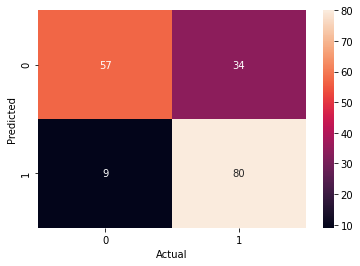

In [28]:
from sklearn.metrics import accuracy_score,roc_auc_score,recall_score,confusion_matrix,precision_score


y_test_pred = classifier.predict(X_test_new)


print('Accuracy test: ',accuracy_score(y_test,y_test_pred))
print('\n\n')

print('ROC AUC test: ',roc_auc_score(y_test,y_test_pred))
print('\n\n')
print('Recall test: ',recall_score(y_test,y_test_pred))
print('\n\n')


cf_matrix = confusion_matrix(y_test, y_test_pred)
h=sns.heatmap(cf_matrix, annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [29]:
X.iloc[:,selector.get_support()].columns.tolist()

['IgG phase I',
 'Site_Humanitas Castelli',
 'Site_Humanitas Gavazzeni',
 'Site_Humanitas Rozzano',
 'IgG class phase I_LOW',
 'IgG class phase I_MED',
 'Fever_1.0',
 'Muscle pain_1.0',
 'Asthenia_1.0',
 'Anosmia/dysgeusia_1.0',
 'Chest pain_1.0',
 'Anosmia/dysgeusia_PhaseII_1.0',
 'Past neoplasia_1.0',
 'Surgery in the last year_1.0']

In [66]:
import statsmodels.api as sm
#X = X.iloc[:,selector.get_support()]
X_logit = sm.add_constant(X.iloc[:,selector.get_support()])
model = sm.Logit(y,X_logit)
results = model.fit(maxiter=35)

         Current function value: 0.511286
         Iterations: 35


/Users/rikhy96/opt/anaconda3/envs/ML-DL/lib/python3.8/site-packages/statsmodels/base/https://urldefense.proofpoint.com/v2/url?u=http-3A__model.py&d=DwIGAg&c=5rLNXN0mp_7LMh3Fds96xpjyD06ZuE2RU7zikolS0lg&r=qdlU_WWXwV0WIKmg1RQoEJSHC70Wr-x0JP9LkXcuxfBwRGzELWnhcndCrmafu4bs&m=RuxRWzRM550d34k3W4FOmaOUlybIYdGZKleT0N3FC68&s=6CgThP5EW1lRsJBXukjs40tYbMlt3FpyQDqhwrVbDWU&e= :566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [67]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  899
Model:                          Logit   Df Residuals:                      884
Method:                           MLE   Df Model:                           14
Date:                Fri, 05 Feb 2021   Pseudo R-squ.:                  0.2623
Time:                        18:34:57   Log-Likelihood:                -459.65
converged:                      False   LL-Null:                       -623.09
Covariance Type:            nonrobust   LLR p-value:                 2.849e-61
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0978      0.219     -0.446      0.655      -0.527       0.332
IgG phase I                      -0.0011      0.002     -0.580      0.562      -0.005       0.003
Site_Humanitas Castelli           0.4447      0.333      1.335      0.182      -0.208       1.098
Site_Humanitas Gavazzeni          0.2277      0.231      0.984      0.325      -0.226       0.681
Site_Humanitas Rozzano           -0.2938      0.219     -1.344      0.179      -0.722       0.135
IgG class phase I_LOW            26.2854   5.15e+04      0.001      1.000   -1.01e+05    1.01e+05
IgG class phase I_MED            -1.6212      0.227     -7.138      0.000      -2.066      -1.176
Fever_1.0                         0.2060      0.198      1.038      0.299      -0.183       0.595
Muscle pain_1.0                  -0.0598      0.198     -0.302      0.762      -0.448       0.328
Asthenia_1.0                      0.0827      0.202      0.410      0.682      -0.313       0.478
Anosmia/dysgeusia_1.0             0.8078      0.194      4.157      0.000       0.427       1.189
Chest pain_1.0                    0.4491      0.252      1.781      0.075      -0.045       0.944
Anosmia/dysgeusia_PhaseII_1.0     0.3261      0.337      0.967      0.333      -0.335       0.987
Past neoplasia_1.0               -1.2688      0.512     -2.476      0.013      -2.273      -0.264
Surgery in the last year_1.0     -0.7131      0.430     -1.659      0.097      -1.556       0.129
=================================================================================================
"""

In [50]:
coef = np.exp(results.params[results.pvalues<0.1])

In [51]:
results.conf_int(alpha = 0.05)

0             1
const                             -0.527176      0.331608
IgG phase I                       -0.004628      0.002516
Site_Humanitas Castelli           -0.208404      1.097901
Site_Humanitas Gavazzeni          -0.225719      0.681068
Site_Humanitas Rozzano            -0.722197      0.134621
IgG class phase I_LOW         -97673.896100  97726.336560
IgG class phase I_MED             -2.066375     -1.176052
Fever_1.0                         -0.183034      0.595039
Muscle pain_1.0                   -0.447541      0.327937
Asthenia_1.0                      -0.312594      0.477900
Anosmia/dysgeusia_1.0              0.426955      1.188733
Chest pain_1.0                    -0.045233      0.943508
Anosmia/dysgeusia_PhaseII_1.0     -0.334751      0.986950
Past neoplasia_1.0                -2.273269     -0.264362
Surgery in the last year_1.0      -1.555504      0.129314

In [52]:
index_significance = results.params[results.pvalues<0.1].index

In [53]:
low_conf = np.exp(results.conf_int(alpha = 0.05).loc[index_significance].iloc[:,0])
high_conf = np.exp(results.conf_int(alpha = 0.05).loc[index_significance].iloc[:,1])

In [55]:
results.params[results.pvalues<0.1].index

Index(['IgG class phase I_MED', 'Anosmia/dysgeusia_1.0', 'Chest pain_1.0',
       'Past neoplasia_1.0', 'Surgery in the last year_1.0'],
      dtype='object')

In [106]:
col = ['3.8<IgG<12','Anosmia/dysgeusia','Chest Pain','Past Neoplasia']

(array([0, 1, 2, 3]),
 [Text(0, 0, '3.8<IgG<12'),
  Text(0, 1, 'Anosmia/dysgeusia'),
  Text(0, 2, 'Chest Pain'),
  Text(0, 3, 'Past Neoplasia')])

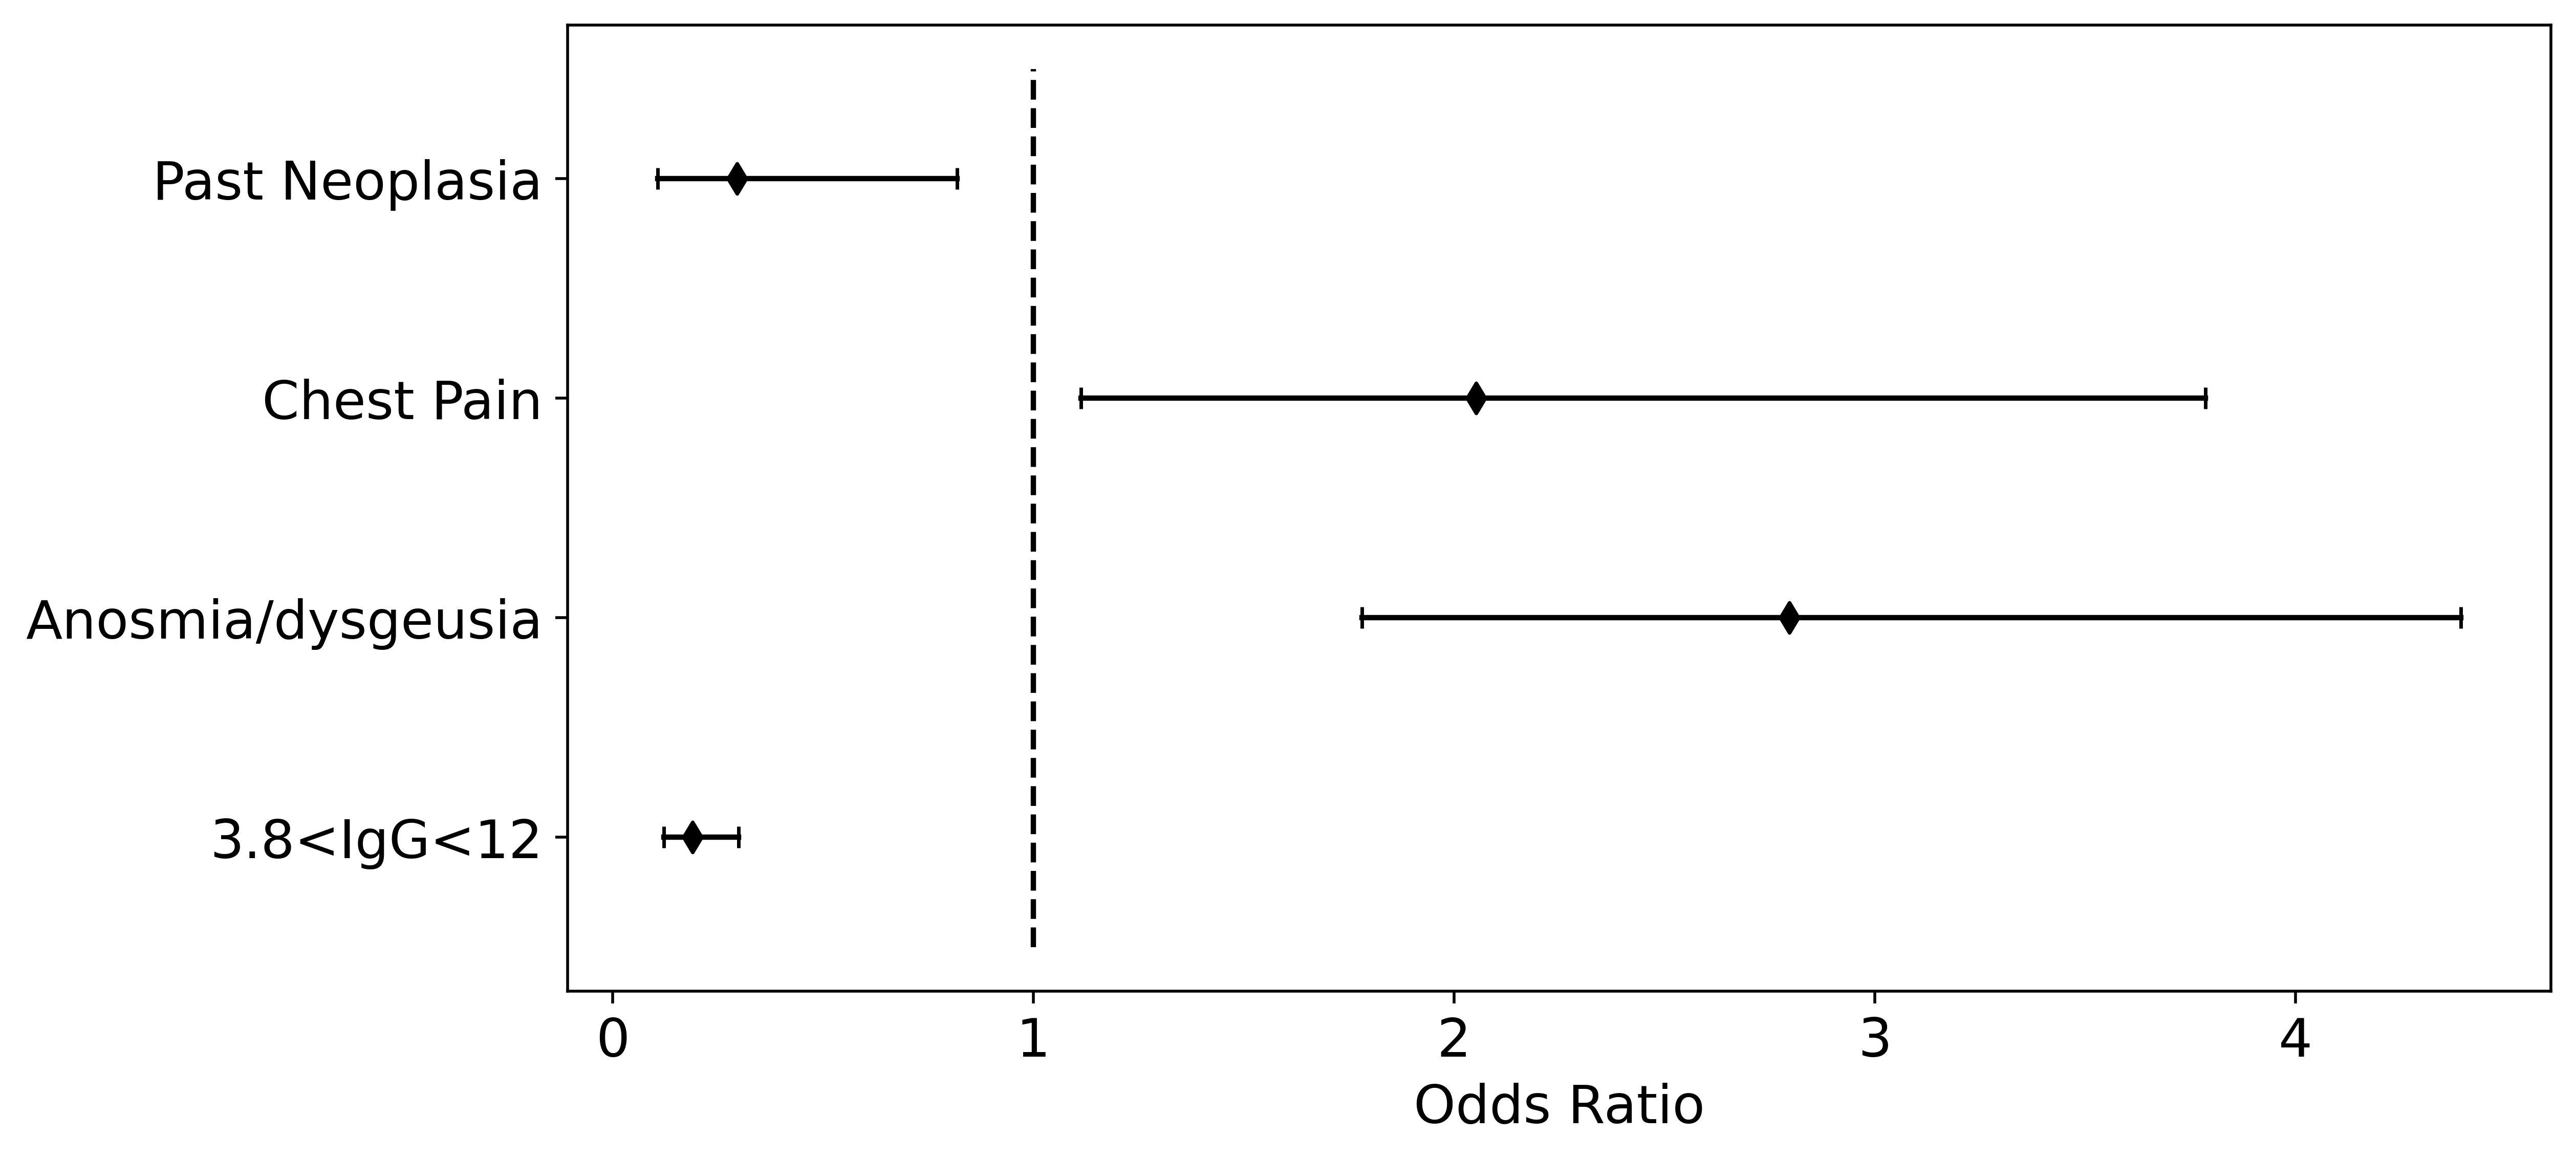

In [107]:
import matplotlib



plt.figure(figsize=(10,5),dpi = 500)
for x in range(len(col)):
    
    plt.plot([low_conf[x],high_conf[x]],[x,x],'k-|')
    plt.scatter(coef[x],x,c='k',marker = 'd')
    
plt.plot([1,1],[-0.5,len(col)-0.5],'k--')
plt.yticks(np.arange(len(col)),col)
plt.xlabel ('Odds Ratio',fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
